### Understanding classifier output in potentially Bayesian analysis of photon data 

In the notes below, I am interpreting both the code and the theory documentation that has been given to me so far. I am keen to figure out where my interpretation matches or diverges from the existing materials. The notes below are draft and would benefit from many pairs of eyes to see if I've messed up a step somewhere.

### Single Msmt

Context: In this section, I am trying to interpret the existing code for a single measurement. I wouldn't necessarily expand an inference problem this way, but I'm doing my best to assume that the code is correct and I assume that the form of the code is not explained via Bayes rule but an entirely frequentist approach to inference.

Let:

$\phi \in [0, 1]$ : Born probability of observing up-state

$ D $ : Photon data (vectorised image) for a single msmt
    
$ s $ : Observed state of the qubit (up or down) for a single msmt


----------------

Consider the joint distribution over the random variates, $p(\phi, s, D)$:

\begin{align}
p(\phi, s, D)  &= p(\phi | s, D) p(s | D) p(D) \qquad \text{product rule} \\
p(\phi, D)  &= \sum_{s \in [0, 1]} p(\phi | s, D) p(s | D) p(D) \qquad \text{integrate s on both sides} \\
&= p(D) \sum_{s \in [0, 1]} p(\phi | s, D) p(s | D)  \qquad \text{re-arrange} \\
\end{align}

Now, divide both sides by $p(D)$. 

\begin{align}
LHS  &= \frac{p(\phi | D) p(D)}{p(D)} = p(\phi | D)\\
RHS &= \sum_{s \in [0, 1]} p(\phi | s, D) p(s | D) \\
\implies p(\phi | D) &= \sum_{s \in [0, 1]} p(\phi | s, D) p(s | D)
\end{align}

What do we know about $p(\phi | s, D), s \in \{0,1\}$ after a single msmt? Well, suppose you take an image (given $D$) and you correctly identify the state of the qubit (given $s$). This is either 0 or 1 . What do you know about $\phi$? Well, pretty much nothing. If you get a zero, then you might suspect that $\phi < 0.5$ or if you get a 1, you might suspect $\phi > 0.5$. But you don't know for sure, even a biased coin will flip to low-probability outcomes once. 

So the shape of $p(\phi | s=1, D)$ is flat and the shape of $p(\phi | s=0, D)$ is also flat and they must add together to unity over the total set of two outcomes for $s$. The discrete approximation to a continuous uniform distribution is determined by making an array with small step sizes, as in the code. 

This concludes one way of analysising a single msmt in a way that's consistent with the code (I think!).

Now, we assume that the single msmt case is true and we turn to the problem of doing inference with multiple msmts.

### Multiple msmts

Let the mathcal $D$ represent a measurement record (i.e. a set of images):

$\mathcal{D}_N:= \{ D_1, D_2, ..., D_N \}$ : the set of $N$ images

#### Frequentist approach - what I think your code is doing:

Assume that each trial (for each image) be an independent event. Then the probability of event $D_1$ and $D_2$ and ... $D_N$ is just the product of these distributions:

\begin{align}
p(\phi |\mathcal{D}_N) &= p(\phi_1, \phi_2, ... \phi_N |\mathcal{D}_N) \quad \text{$\phi$ invariant, so indexing doesnt matter} \\
&= p(\phi_1 |\mathcal{D}_N) p(\phi_2|\mathcal{D}_N) ... p(\phi_N |\mathcal{D}_N)\quad \text{independent trials} \\
&= p(\phi_1 |\mathcal{D}_1) p(\phi_2|\mathcal{D}_2) ... p(\phi_N |\mathcal{D}_N)\quad \text{delete future data} \\
&= p(\phi_1 |D_1) p(\phi_2|D_2) ... p(\phi_N |D_N)\quad \text{markov assumption on data record ($\mathcal{D} \to D$)} \\
&= \prod_{i=1}^{N}p(\phi_i |D_i) 
\end{align}

We substitute the single msmt case into the last line:

\begin{align}
p(\phi |\mathcal{D}_N) &= \prod_{i=1}^{N}p(\phi_i |D_i) \\
&= \prod_{i=1}^{N}\sum_{s_i \in [0, 1]} p(\phi_i | s_i, D_i) p(s_i | D_i)
\end{align}

This appears to be what is being implemented by code.
If so, the code is doing a frequentist analysis (averaging) of the classifier output, and the code should agree with the empirical mean of taking biased coin tosses based on the classifier data.

#### Full Bayesian approach - what I think you want to do:

To do the full Bayesian approach properly, we might as well assume that we know nothing about $\phi$ including the fact that we don't know if its invariant. The frequentist approach can't handle drifts in $\phi$. 

We want $p(\phi_N |\mathcal{D}_N)$ and we will get this by expanding the data record, namely, we take out the last image:

\begin{align}
p(\phi_N |\mathcal{D}_N) & = p(\phi_N |\mathcal{D}_{N-1}, D_N) \quad \text{Take out the last image from the set} \\
&= \frac{p(D_N |\phi_N, \mathcal{D}_{N-1})  p(\phi_N |\mathcal{D}_{N-1})}{p(D_N |\mathcal{D}_{N-1})} \quad \text{Bayes Rule on most recent image} \\
&= \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi_N, \mathcal{D}_{N-1}) p(\phi_N |\mathcal{D}_{N-1}) \quad \text{Re-arrange to see normaliser, msmt model / likelihood, and last term} \\
&= \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi_N, \mathcal{D}_{N-1})  \int p(\phi_{N} |\phi_{N-1},\mathcal{D}_{N-1})  p(\phi_{N-1} |\mathcal{D}_{N-1}) \quad  d\phi_{N-1}
\end{align}

The last line is just reverse-marginalising over the state $\phi_{N-1}$. If the procedure doesn't make sense, let's just look at the terms in the last line:

$p(\phi_{N} |\mathcal{D}_{N})$ : Posterior at the current image and all previous images

$\frac{1} {p(D_N |\mathcal{D}_{N-1})}$ : Normalisation at each incoming image

$p(D_N |\phi_N, \mathcal{D}_{N-1}) $ : Msmt model / likelihood of the current image

$p(\phi_{N} |\phi_{N-1},\mathcal{D}_{N-1}) $ : Transition probability (how to we take posterior from all previous images to next image)

$p(\phi_{N-1} |\mathcal{D}_{N-1})$ : Posterior before receiving the current image

--------

Now we make three simplifying assumptions:

1. Markov assumption on the state transition: $p(\phi_{N} |\phi_{N-1},\mathcal{D}_{N-1}) \to p(\phi_{N} |\phi_{N-1})$
2. Invariance of $\phi$ via delta function: $p(\phi_{N} |\phi_{N-1}) := \delta(\phi_{N} - \phi_{N-1})$
3. Markov assumption on state measurement model: $p(D_N |\phi_N, \mathcal{D}_{N-1})  \to p(D_N |\phi_N)  $


\begin{align}
p(\phi_N |\mathcal{D}_N) & = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi_N, \mathcal{D}_{N-1})  \int p(\phi_{N} |\phi_{N-1},\mathcal{D}_{N-1})  p(\phi_{N-1} |\mathcal{D}_{N-1}) \quad  d\phi_{N-1}  \quad \text{start with this bayesian eqn (no approx. made)}\\
& = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi_N, \mathcal{D}_{N-1})  \int p(\phi_{N} |\phi_{N-1})  p(\phi_{N-1} |\mathcal{D}_{N-1}) \quad  d\phi_{N-1} \quad \text{Markov assumption on the state transition} \\
p(\phi |\mathcal{D}_N)  & = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi, \mathcal{D}_{N-1})  p(\phi |\mathcal{D}_{N-1}) \quad \text{Invariance of $\phi$} \\
& = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi)  p(\phi |\mathcal{D}_{N-1}) \quad \text{Markov assumption on state measurement model} \\
\end{align}

Here:

$p(\phi |\mathcal{D}_{N})$ : Posterior at the current image and all previous images

$\frac{1} {p(D_N |\mathcal{D}_{N-1})}$ : Normalisation at each incoming image

$p(D_N |\phi)$ : Msmt model / likelihood of the current image

$p(\phi |\mathcal{D}_{N-1})$ :Posterior before receiving the current image

Note that this is a recursive bayesian solution and $p(\phi |\mathcal{D}_{0})$ is the prior for $\phi$.

The only unknown term is the measurement model or the likelihood function. The classifier, physically, must be part of the measurement model.  The measurement model is usually designed using some knowledge of noise, namely, if our model  $\phi$, explains everything in the data $D_N$, then the left over is the distribution of noise process $p(D_N |\phi)$. 

However, we can't link $\phi$ to $D_n$ without expanding over states. Below, consider two different ways to write the measurement model.

------

##### (a) Measurement model: $p(D_N |\phi)$  using output of the classifier

The term $p(D_N |\phi)$ refers to a single image, $D_N$ given $\phi$. This is exactly the single measurement case, and we could write:

\begin{align}
p(D_N |\phi) & = \frac{p(D_N)} { p(\phi) } p(\phi |D_N ) \quad \text{from Bayes rule} \\
p(\phi | D_N) &= \sum_{s \in [0, 1]} p(\phi | s, D_N) p(s | D_N) \quad \text{from single msmt case} \\
p(D_N |\phi) & =  \frac{p(D_N)} { p(\phi) } \sum_{s \in [0, 1]} p(\phi | s, D_N) p(s | D_N) \quad \text{proposed Bayesian likelhood} 
\end{align}

Then we can substitute this into the main equation to get:

\begin{align}
p(\phi |\mathcal{D}_{N}) & = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi)  p(\phi |\mathcal{D}_{N-1}) \\
p(\phi |\mathcal{D}_{N}) & = \frac{1} {p(D_N |\mathcal{D}_{N-1})} \left( \frac{p(D_N)} { p(\phi) } \sum_{s \in [0, 1]} p(\phi | s, D_N) p(s | D_N)  \right) p(\phi |\mathcal{D}_{N-1}) \\
\end{align}


Note that if $p(D_N |\mathcal{D}_{N-1}) = p(D_N)$ and $p(\phi)$  is uniform, then this can only ever be the frequentist approach.


------

##### (b) Measurement model: $p(D_N |\phi)$  using  expansion over states , $s$

Here, we can expand the measurement model,  $p(D_N |\phi)$, a slightly different way, over the state $s$ observed by looking at the $N$th image:

\begin{align}
p(D_N |\phi) & = \sum_{s \in [0, 1]} p(D_N |\phi, s) p(s | \phi) \\
\end{align}

Then we can substitute this into the main equation to get:

\begin{align}
p(\phi |\mathcal{D}_{N}) & = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(D_N |\phi)  p(\phi |\mathcal{D}_{N-1}) \\
& = \frac{1} {p(D_N |\mathcal{D}_{N-1})} p(\phi |\mathcal{D}_{N-1})  \sum_{s \in [0, 1]} p(D_N |\phi, s) p(s | \phi)
\end{align}

Here:

$p(s | \phi)$ : This is defined by Born's rule / quantum mechanics (prob-amplitudes squared)

$p(D_N |\phi, s) $ : These are detection or measurement error distributions.

Typically, you would find out what $p(D_N |\phi, s) $  is in the lab as bright and dark count rates for engineered true states. One could fit a Gaussian or some other kind of distribution by doing lots of calibiration runs (just like training for a classifier). Suppose the form of the noise is given by the function, $f(\cdot)$, where $\mu^{(j)}, j = 1, 2, ..., J$ is the $j$-th moment of the noise distribution, where you need all $J$ moments depending on how funky the noise is. For example, Gaussian noise, you'd only need to estimate two moments (mean and variance with $J=2$) in the calibiration runs or optimisation procedure. 

\begin{align}
p(D_N |\phi, s)  : = f(D_N , \mu_1, \mu_2, ...\mu_J) \\
\end{align}

Hence, $p(D_N |\phi, s) $ takes the image, $D_N$ and the prior knowledge about detector noise parameterised by $\mu^{(j)}, j = 1, 2, ..., J$  and spits out a score for the $D_N$ image, given the model. 

Note that the knowledge of detector noise, parameterised by $\mu^{(j)}, j = 1, 2, ..., J$, allows you to correct for non-zero mean noise processes and so you can do better than the frequentist approach.

### What does the classifer actually give? It's not  $p(s | D_N)$ 

At present, we assume that the class probabilities given out by the classifer are actually $p(s | D_N)$ 

Actually, the class probabilities are not $p(s | D_N)$ but an estimate of the true $p(s | D_N)$. 

The classifier develops a map (a bunch of trees where each node looks at randomly configured chunks of images, where depth is arbirary and node decision points are inferred during training). 

So the actual inference associated with the classifier is the assumption something like (informally):

\begin{align}
\lim_{N \to \infty} \quad \mathbb{E} [p(s | D_N) - \hat{p}(s | D_N, \Theta) ] = 0 
\end{align}

The expectation is taken over samples of data  (labels, images) over the true distribution of all possible data and labels, and it is asympotic with respect to the total amount of data, $N$, and choice of classifier configurations $\Theta$ (e.g. how to partition trees). 

Classifers do not have to be ideal for many reasons: for example, even with a large samples and perfect configurations, one may not be sampling the true distribution enough or the presence of certain types of noise makes it impossible to build the ideal map from data to labels. 

Further, $\hat{p}(s | D_N, \Theta)$ is again a way to score the classifer prediction and there is a bunch of different metrics you can use to score classifer predictions, each of them are robust to different types of physical applications, and noise. 

All in all, $ \hat{p}(s | D_N, \Theta)$ is an estimate of $p(s | D_N) $ and there is no garantee that it is a good estimator (e.g. unbiased estimate in the means, variances, so on). 


### Conclusion / Expectations of the Code

I think the analysis of a classifer output is currently not clear. In addition, adding bayesian analysis (or a frequentist one) will lead to incorrect conclusions when the classifer output is being mis-interpreted. 

For the current code, my expectations are that:

1. At best: code output matches the empirical mean. 
2. At worst: code output adds a systemic bias. 


### Some playing around with deterministic data

The code below produces the following image. It would be great to check the code and then discuss the image.

**Rows**: represents engineered Data for input into Bayes analysis of code. We are only testing the bayesian analysis (as-is) on top of the classifier output.  Data is play-data and represents class probability of an up-state from a classifier for a single image (i.e. a probability from the classifier expressing confidence about the label of `1` assigned to an image)

    Data_0: Bad Classifer, with 1 image / msmt. Here, `bad' means that the class probability is not near 0 or 1, and the classifer is not sure whether it classified an image correctly. 

    Data_1: Bad Classifer, with many images / msmt.

    Data_2: Ideal Classifer, with many images / msmt. Underlying detector error is assumed zero mean.

    Data_3: Confident Classifer, with many images / msmt. Underlying detector error has +ve bias that skews class probabilities positively.

    Data_4: Confident Classifer, with many images / msmt. Underlying detector error has -ve bias that skews class probabilities negatively.

**Cols**: represents increasing total images / measurements from left to right

**X-axis**: Values of $\phi$, where $\phi$ is a continuous random variable between 0 and 1, modelled in discrete analysis via a finite resolution in the existing code.

**Y-axis**: $P(\phi | \mathcal{D}_N)$ either via Bayes analysis (as-is) or empirical means

**Output lines**: 

    Red line : Bayes analysis (as-is) of Data.

    Blue line : Bayes analysis with different normalisation of Data.

    Green line: Empirical mean (using biased coinflips and frequentist approach)

    Black line: True born probability

#### Interpretation of figure.

This figure does not calculated expected errors over all possible truths and datasets. If we define random generations of truths and fake datasets, and calculate performance, then we make assumptions about noise models, and the discussion of noise models is beyond the scope of this document.

If one was to repeat the analysis with randomly generated truths and datasets, then the expected value of the gap between green/blue/red and black lines over many realisations of truth and data will capture both (a) estimation error (introduced by our inference method) and (b) approximation error ( true error between what the data allows us to learn, and the actual truth). However, this is the next step that will be deferred until we get agreement about what we are trying to do theoretically.

Hence, small amounts of perfectly deterministic truths and deterministic fake-data is used, and we try to observe what our equations do for these deterministic perturbations. 

I make these observations below.
    
** Observations**:

1. If the classifer is ideal / confident and we are in the large data limit / repeated trials, then:

    (a) we get agreement between code and empirical mean.
    
    (b) the code / empirical mean do not need to approach the true value of $\phi$  if detection errors are biased.
    
    Comments: Refer bottom two rows. Colored lines do not match the black line. This is expected if the code is reducing to the frequentist approach, with no additional information carried into the inference procedure via a Bayesian measurement model regarding the underlying bias in  "detection/ msmt errors".
    
2. If the classifer is unsure about assigning to labels to data, then substituting classifier output into any bayesian or frequentist approach will not be generally easy to interpret / incorrect in the large data limit.

    Comment: If the classifier is not sure about a prediction, then given the current code, it will not be possible to distinguish sources of classifier uncertainity to its constituent sources - namely classification errors, so called "projection" errors, measurement/detection errors.

3. The empirical mean calculation using classifier data seems to be the easiest interpretation of the classifer, as it converges to the true $\phi$ in the large data limit unless we expect any error process to be biased. NB: The empirical mean uses each classifier prediction as an estimate to do a noisy biased coin flip to get the final estimated label for an image. I think theoretically, the coin-flip takes into account classification errors and so called projection noise; but should be blind to any apriori models of msmt/detection noise.


<img src="bayes_classifer_expt_ipynb.png">

#### Code

In [1]:
import numpy as np
import matplotlib
fsize=8
# Set global parameters
matplotlib.rcParams['font.size'] = fsize # global
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['mathtext.default'] ='regular' # makes mathtext mode Arial. note mathtext is used as ticklabel font in log plots

# Set global tick mark parameters
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5
matplotlib.rcParams['xtick.labelsize']= fsize
matplotlib.rcParams['ytick.labelsize'] = fsize
matplotlib.rcParams['xtick.minor.visible'] = False
matplotlib.rcParams['ytick.minor.visible'] = False
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in divide


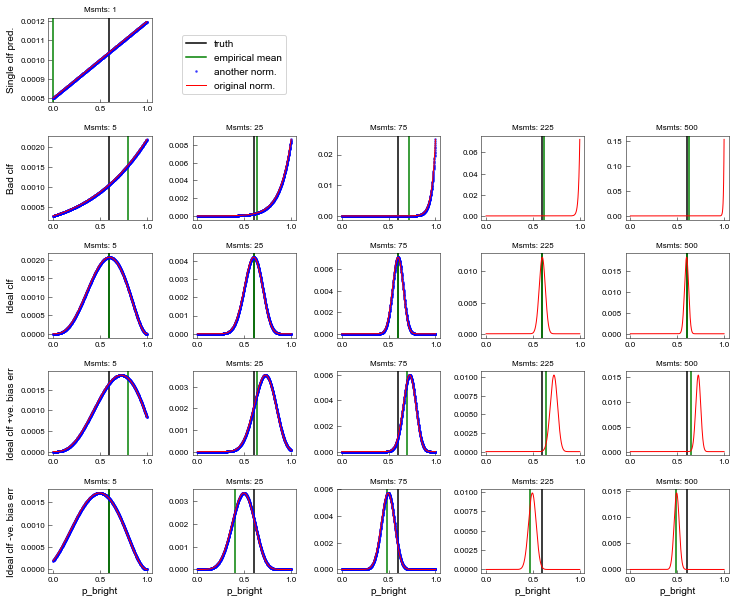

In [14]:
resoln = 1001
truth =  0.6
repetitions = [1, 5, 15, 45, 100]

gslayout = gs.GridSpec(nrows= 5, ncols=len(repetitions), 
                       hspace=0.4, wspace=0.4, left=0.1, 
                       right=0.9, top=0.99, bottom=0.01)

data_0 = [0.6] # just a single image from a classifier
data_1 = [0.6, 0.57, 0.61, 0.62, 0.6] # a bad classifer
data_2 = [0.0, 0.0, 1.0, 1.0, 1.0] # an ideal classifer
data_3 = [0.1, 0.2, 1.0, 1.0, 1.0] # an ideal classifer on positively biased detector
data_4 = [0.0, 0.0, 0.9, 0.88, 0.7] # an ideal classifer on negatively biased detector
   
titles = ['Single clf pred.', 'Bad clf', 'Ideal clf', 'Ideal clf +ve. bias err', 'Ideal clf -ve. bias err']

fig = plt.figure(figsize=(30/2.54, 20/2.54))

idx_data = 0 
for database in [data_0, data_1, data_2, data_3, data_4]:
    
    idx_rept = 0 
    for repts in repetitions:
        
        if idx_data == 0 and idx_rept > 0:
            continue
        
        # Fake data (classifier output)5
        data = database*repts
        prob_up = np.asarray(data)[:, np.newaxis] # output of the classifier 
        prob_down = 1.0 - prob_up # both outputs from classifier always add to one

        # Empirical mean (based on classifier)
        shots = [np.random.binomial(n=1, p=data[idx]) for idx in range(len(data))]
        empirical_mean = np.mean(shots)

        # Up and down projections (# # Bugfix: 1 is not included)
        project_up = np.linspace(0, 1, resoln)
        project_down = (1.0 - project_up)

        # Original code
        total_elements = prob_up * project_up + prob_down * project_down
        state_likelihood_old = np.prod(total_elements, axis=0)
        state_likelihood_old /= np.sum(state_likelihood_old)

        # Modify original code to normalise for each new data point
        normalisers = 1.0 / np.sum(total_elements, axis=1)
        norm_total_elements = [normalisers[idx] * total_elements[idx] for idx in range(len(data))]
        state_likelihood_new = np.prod(norm_total_elements, axis=0)
        state_likelihood_new /= np.sum(state_likelihood_new)
        
        # Graphing
        ax = fig.add_subplot(gslayout[idx_data, idx_rept])
        ax.set_title('Msmts: %s' %(len(data)), fontsize=8)
        
        ax.axvline(x=truth, c='k', label='truth')
        ax.axvline(x=empirical_mean, c='g', label='empirical mean')
        ax.plot(project_up, state_likelihood_new, 'bo', ms=1.6, alpha=0.6, label='another norm.')
        ax.plot(project_up, state_likelihood_old, 'r', lw=1, label='original norm.')
        
        if idx_rept == 0:
            ax.set_ylabel(titles[idx_data])
        
        if idx_rept == 0:   
            if idx_data == 0:
                ax.legend(loc=9, bbox_to_anchor=(1.8, 0.85))  
        
        if idx_data == 4:
            ax.set_xlabel('p_bright')
        
        idx_rept += 1
    idx_data += 1
    
plt.savefig('bayes_classifer_expt.svg', format='svg', dpi=400)
plt.show()